In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the CSV file
df = pd.read_csv('p_data50000.csv')


In [2]:
df.tail()

,id,gender,age,topic,sign,date,text,Word_count
49833,1673216,male,17,Student,Taurus,"03,May,2004",one morn got bed check phone someon knock door...,241
49834,1673216,male,17,Student,Taurus,"13,June,2004",edit proof http img35 photobucket com album v1...,265
49835,1673216,male,17,Student,Taurus,"30,July,2004",human heart heart collect particl molecul atom...,238
49836,4260903,female,34,indUnk,Virgo,"23,August,2004",ran around clean morn grandma mom dad come 11a...,214
49837,4260903,female,34,indUnk,Virgo,"18,August,2004",want consid rawfoodist ye like make one word l...,282


In [3]:
# Assume the CSV has columns 'text' and 'label'
texts = df['text'].tolist()
labels = df['gender'].tolist()

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Hyperparameters
vocab_size = 20000
max_length = 300  # Adjust based on your data
embedding_dim = 100  # Size of GloVe vectors

# Tokenization and padding
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
X = pad_sequences(sequences, maxlen=max_length)
y = np.array(labels)

print(df['gender'].value_counts())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


female    26041
male      23797
Name: gender, dtype: int64


In [5]:
# Load GloVe embeddings
embedding_index = {}
glove_path = 'glove/glove.twitter.27B.100d.txt'  # Update with the path to your GloVe file

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create an embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
       


In [6]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights: ", class_weights)

Class Weights:  {0: 0.9572629051620648, 1: 1.046731425571016}


In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Build the  CNN model
model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=max_length, 
              weights=[embedding_matrix], 
              trainable=True),  # Allow fine-tuning of embeddings
    Conv1D(128, 5, activation='relu'),
    Dropout(0.5),  # Add dropout to prevent overfitting
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # Use 'sparse_categorical_crossentropy' for multi-class classification
              metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model with class weights
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=callbacks, class_weight=class_weights)


Epoch 1/10
997/997 [==============================] - 51s 51ms/step - loss: 0.6545 - accuracy: 0.6242 - val_loss: 0.6385 - val_accuracy: 0.6817
Epoch 2/10
  2/997 [..............................] - ETA: 52s - loss: 0.5825 - accuracy: 0.7812 

/Users/abhaydevraj/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


997/997 [==============================] - 53s 53ms/step - loss: 0.5883 - accuracy: 0.7023 - val_loss: 0.5981 - val_accuracy: 0.6776
Epoch 3/10
997/997 [==============================] - 53s 53ms/step - loss: 0.5183 - accuracy: 0.7527 - val_loss: 0.5756 - val_accuracy: 0.7062
Epoch 4/10
997/997 [==============================] - 55s 55ms/step - loss: 0.4492 - accuracy: 0.7976 - val_loss: 0.5885 - val_accuracy: 0.6917
Epoch 5/10
997/997 [==============================] - 53s 54ms/step - loss: 0.3842 - accuracy: 0.8368 - val_loss: 0.6204 - val_accuracy: 0.6854
Epoch 6/10
997/997 [==============================] - 54s 54ms/step - loss: 0.3179 - accuracy: 0.8735 - val_loss: 0.6595 - val_accuracy: 0.6949
Epoch 7/10
997/997 [==============================] - 55s 55ms/step - loss: 0.2561 - accuracy: 0.9007 - val_loss: 0.7184 - val_accuracy: 0.6884
Epoch 8/10
997/997 [==============================] - 57s 57ms/step - loss: 0.2086 - accuracy: 0.9215 - val_loss: 0.8180 - val_accuracy: 0.6907


312/312 [==============================] - 4s 12ms/step - loss: 0.5776 - accuracy: 0.6930
Test Accuracy: 0.6930176615715027
312/312 [==============================] - 4s 12ms/step
F1 Score: 0.6907044550053287
Precision: 0.7065327264026035
Recall: 0.6930176565008026
Confusion Matrix:
[[3123 2093]
 [ 967 3785]]
Classification Report:
              precision    recall  f1-score   support

      female       0.76      0.60      0.67      5216
        male       0.64      0.80      0.71      4752

    accuracy                           0.69      9968
   macro avg       0.70      0.70      0.69      9968
weighted avg       0.71      0.69      0.69      9968



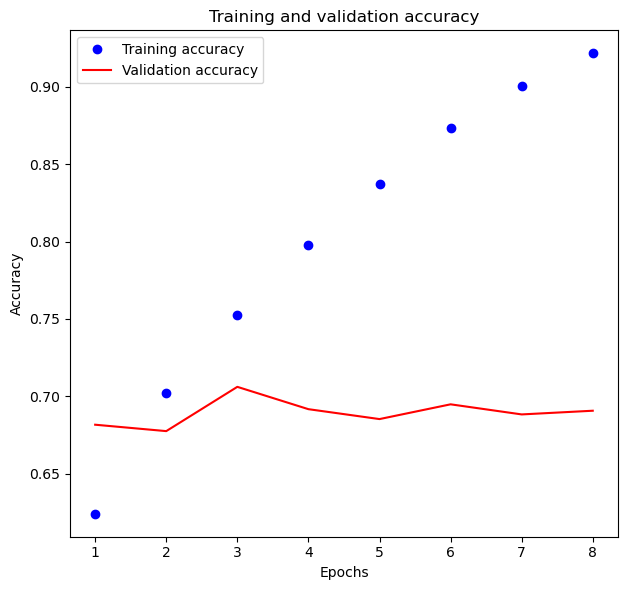

In [11]:
#  Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Predict on the test data
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)  # Adjust for binary classification

# Compute metrics
f1 = f1_score(y_test, y_pred_classes, average='weighted')
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{class_report}")

# Plot training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()